<a href="https://colab.research.google.com/github/tada3/titanic/blob/master/Titanic2_retry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

Titanic同乗者のグループ（Ticketや家族関係を基に決定）を認識し、そのグループ内での他のメンバーが生存したかどうかを考える。例えば、グループ内で成人男子が死んでいれば他のメンバーは助かっている確率が高い。
以下の数値がFeatureの候補
グループ内で生存した成人男子の数
グループ内で死亡した成人男子の数
グループ内で生存した非成人男子の数
グループ内で死亡した非成人男子の数


# 0. 準備

In [323]:
!mkdir -p ~/.kaggle
!cp drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pip install kaggle

cp: cannot stat 'drive/MyDrive/Kaggle/kaggle.json': No such file or directory


In [324]:
!kaggle competitions download -c titanic

train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [325]:
import numpy as np
import pandas as pd
import random
import os

def random_seed(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)

random_seed(666)

In [326]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [327]:
def survived(df):
  count = df[['Survived', 'PassengerId']].groupby('Survived').count()
  total = count['PassengerId'].sum()
  count['rate'] = (count['PassengerId'] / total)
  return count

# 1. Load Data

In [328]:
train = pd.read_csv('train.csv')
train.describe()

PassengerId    Survived      Pclass  ...       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  ...  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642  ...    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071  ...    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000  ...    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000  ...    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000  ...    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000  ...    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000  ...    8.000000    6.000000  512.329200

[8 rows x 7 columns]

In [329]:
test = pd.read_csv('test.csv')
test.describe()

PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200

In [330]:
all = pd.concat([train, test], sort=False).reset_index(drop=True)
all.describe()

PassengerId    Survived  ...        Parch         Fare
count  1309.000000  891.000000  ...  1309.000000  1308.000000
mean    655.000000    0.383838  ...     0.385027    33.295479
std     378.020061    0.486592  ...     0.865560    51.758668
min       1.000000    0.000000  ...     0.000000     0.000000
25%     328.000000    0.000000  ...     0.000000     7.895800
50%     655.000000    0.000000  ...     0.000000    14.454200
75%     982.000000    1.000000  ...     0.000000    31.275000
max    1309.000000    1.000000  ...     9.000000   512.329200

[8 rows x 7 columns]

# 2. グループの認識

In [331]:
name = all['Name'].str.split("[.,]", 2, expand=True)
name.columns = ["family_name", "title", "given_name"]
name['family_name'] = name['family_name'].str.strip()
name['title'] = name['title'].str.strip()
name[name['family_name'].str.contains('-')]
name['maiden_name'] = name['given_name'].str.extract('([A-Za-z]+)\)', expand=False)
name['maiden_or_family'] = name['maiden_name']
name.loc[name['maiden_or_family'].isnull(), 'maiden_or_family'] = name['family_name']
name

family_name   title  ... maiden_name maiden_or_family
0            Braund      Mr  ...         NaN           Braund
1           Cumings     Mrs  ...      Thayer           Thayer
2         Heikkinen    Miss  ...         NaN        Heikkinen
3          Futrelle     Mrs  ...        Peel             Peel
4             Allen      Mr  ...         NaN            Allen
...             ...     ...  ...         ...              ...
1304        Spector      Mr  ...         NaN          Spector
1305  Oliva y Ocana    Dona  ...         NaN    Oliva y Ocana
1306        Saether      Mr  ...         NaN          Saether
1307           Ware      Mr  ...         NaN             Ware
1308          Peter  Master  ...         NaN            Peter

[1309 rows x 5 columns]

In [332]:
name['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Jonkheer          1
Don               1
Lady              1
Dona              1
Capt              1
Mme               1
the Countess      1
Sir               1
Name: title, dtype: int64

In [333]:
all = pd.concat([all, name], axis=1)

In [334]:
all['family_size'] = all['SibSp'] + all['Parch'] + 1
all['family_size'] = all['family_size'].astype(int)
all['ticket_count'] = all.groupby('Ticket')['PassengerId'].transform('count')
all['ticket_count'] = all['ticket_count'].astype(int)

とりあえず、group_idとしてTicketを設定する。Ticketとグループが一致しない人は後で修正する。

In [335]:
all['group_id'] = all['Ticket']

## 2.1. ソロ客

In [336]:
all.loc[(all['family_size']==1) & (all['ticket_count']==1), 'group_type'] = 'solo'
#solo = all[(all['family_size']==1) & (all['ticket_count']==1)]
solo = all[all['group_type']=='solo']
solo

PassengerId  Survived  ...            group_id group_type
2               3       1.0  ...    STON/O2. 3101282       solo
4               5       0.0  ...              373450       solo
5               6       0.0  ...              330877       solo
11             12       1.0  ...              113783       solo
12             13       0.0  ...           A/5. 2151       solo
...           ...       ...  ...                 ...        ...
1301         1302       NaN  ...              365237       solo
1303         1304       NaN  ...              347086       solo
1304         1305       NaN  ...           A.5. 3236       solo
1306         1307       NaN  ...  SOTON/O.Q. 3101262       solo
1307         1308       NaN  ...              359309       solo

[663 rows x 21 columns]

In [337]:
duplicated = solo['family_name'].value_counts()
type(duplicated)

pandas.core.series.Series

In [338]:
duplicated2 = duplicated.to_frame().reset_index()
duplicated2.columns = ['family_name', 'count']
duplicated2

family_name  count
0         Kelly      5
1         Cacic      4
2     Johansson      4
3         Smith      4
4      Svensson      3
..          ...    ...
590    Harknett      1
591  Calderhead      1
592        Roth      1
593      Crease      1
594       Mayne      1

[595 rows x 2 columns]

In [339]:
duplicated3 = duplicated2[duplicated2['count']>1]

In [340]:
solo[solo['family_name']=='Kelly']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
300          301       1.0       3  ...            1     9234        solo
573          574       1.0       3  ...            1    14312        solo
696          697       0.0       3  ...            1   363592        solo
706          707       1.0       2  ...            1   223596        solo
891          892       NaN       3  ...            1   330911        solo

[5 rows x 21 columns]

https://www.encyclopedia-titanica.org/titanic-survivor/anna-katherine-kelly.html 
https://www.encyclopedia-titanica.org/titanic-victim/catherine-mcgowan.html
をみると 301 は1098やその他とグループで乗船したようだが、データからはそれはわからない。
301と他のKellyは関係ないようです。

In [341]:
all[all['Name'].str.contains('McGowan')]

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
22             23       1.0       3  ...            1   330923        solo
1097         1098       NaN       3  ...            1     9232        solo

[2 rows x 21 columns]

In [342]:
solo[solo['family_name']=='Larsson']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
231          232       0.0       3  ...            1   347067        solo
713          714       0.0       3  ...            1     7545        solo

[2 rows x 21 columns]

Larsson についても調べてみたが、232 と714は関係がない。
以上から、soloの客は全部一人で乗船したとみなすことにする。

## 2.2. グループA: ticket_count == family_size

In [343]:
all.loc[(all['family_size']== all['ticket_count']) & (all['ticket_count'] > 1), 'group_type'] = 'a'
group_a = all[all['group_type']=='a']

In [344]:
#group_a_fn = group_a['family_name'].value_counts().to_frame().reset_index()
#group_a_fn_cnt = group_a.groupby('family_name')['PassengerId'].count()
#group_a_fn_cnt
group_a_fn_fsize = group_a.groupby('family_name')['family_size'].describe()
group_a_fn_fsize[group_a_fn_fsize['min'] != group_a_fn_fsize['max']]

count      mean       std  min  25%  50%  75%  max
family_name                                                    
Carter         6.0  3.333333  1.032796  2.0  2.5  4.0  4.0  4.0

In [345]:
group_a[group_a['family_name']=='Carter']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
249          250       0.0       2  ...            2   244252           a
390          391       1.0       1  ...            4   113760           a
435          436       1.0       1  ...            4   113760           a
763          764       1.0       1  ...            4   113760           a
802          803       1.0       1  ...            4   113760           a
854          855       0.0       2  ...            2   244252           a

[6 rows x 21 columns]

これは二つの家族がまじってるだけ。問題なし。

In [346]:
group_a_fn_fsize[group_a_fn_fsize['count'] != group_a_fn_fsize['min']]

count      mean       std  min  25%  50%  75%  max
family_name                                                      
Backstrom        1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Bowerman         1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Carter           6.0  3.333333  1.032796  2.0  2.5  4.0  4.0  4.0
Chibnall         1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Davidson         1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Davies           2.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
Douglas          1.0  3.000000       NaN  3.0  3.0  3.0  3.0  3.0
Duff Gordon      1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Eustis           1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Frauenthal       1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Hansen           1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Hirvonen         1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Jacobsohn        1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Jefferys         2.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
Kink-Heilmann    2.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
Minahan          1.0  3.000000       NaN  3.0  3.0  3.0  3.0  3.0
Mock             1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Newell           1.0  3.000000       NaN  3.0  3.0  3.0  3.0  3.0
Parrish          1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Renouf           1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Richards         2.0  3.000000  0.000000  3.0  3.0  3.0  3.0  3.0
Schabert         1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Shelley          1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Stephenson       1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Strom            1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Thomas           1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Vander Planke    1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0
Ware             1.0  2.000000       NaN  2.0  2.0  2.0  2.0  2.0

グループ客のはずなのになんでcountが1の人がいっぱいいるのか？ Strom でみてみる。

In [347]:
group_a[group_a['family_name']=='Strom']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
205          206       0.0       3  ...            2   347054           a

[1 rows x 21 columns]

In [348]:
group_a[group_a['Ticket']=='347054']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
205          206       0.0       3  ...            2   347054           a

[1 rows x 21 columns]

In [349]:
all[all['Ticket']=='347054']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
205          206       0.0       3  ...            2   347054           a
251          252       0.0       3  ...            2   347054         NaN

[2 rows x 21 columns]

206と252は親子。Ticketが同じでgroup_idも同じなのでこれはOK。しかし、252はSibSpも1になっており、このため、family_size > ticket_countとなっている。
https://www.encyclopedia-titanica.org/titanic-victim/elna-matilda-strom.html
を見ると、兄弟である、 Ernst Ulrik Persson と一緒に乗船しているはず。

In [350]:
all[all['family_name']=='Persson']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
267          268       1.0       3  ...            1   347083         NaN

[1 rows x 21 columns]

252と268が兄弟であることは252の旧姓と268のfamily_nameをマッチさせればできる。。とは言えませんよね。
これで、Cabinも一緒やったら、そうしてもいいけど、CabinがNaNやからなー。残念。

## 2.3. グループB: ticket_count > family_size

In [351]:
all.loc[(all['ticket_count']>all['family_size']), 'group_type'] = 'b'
group_b = all[all['group_type']=='b']
group_b

PassengerId  Survived  Pclass  ... ticket_count  group_id  group_type
6               7       0.0       1  ...            2     17463           b
20             21       0.0       2  ...            2    239865           b
31             32       1.0       1  ...            3  PC 17569           b
50             51       0.0       3  ...            7   3101295           b
52             53       1.0       1  ...            3  PC 17572           b
...           ...       ...     ...  ...          ...       ...         ...
1291         1292       NaN       1  ...            4     36928           b
1294         1295       NaN       1  ...            2    113059           b
1298         1299       NaN       1  ...            5    113503           b
1302         1303       NaN       1  ...            3     19928           b
1305         1306       NaN       1  ...            3  PC 17758           b

[200 rows x 21 columns]

## 2.4. グループC: family_size > ticket_count

兄弟とかで一緒に乗ってるけど、チケットは別ですよ、という人。group_idが一緒になっていないのでそこをなんとかする必要がある。

In [352]:
all.loc[(all['family_size']> all['ticket_count']), 'group_type'] = 'c'
group_c = all[all['group_type'] == 'c']
group_c 

PassengerId  Survived  Pclass  ... ticket_count   group_id  group_type
0               1       0.0       3  ...            1  A/5 21171           c
38             39       0.0       3  ...            2     345764           c
40             41       0.0       3  ...            1       7546           c
68             69       1.0       3  ...            1    3101281           c
69             70       0.0       3  ...            1     315151           c
...           ...       ...     ...  ...          ...        ...         ...
1267         1268       NaN       3  ...            1     315152           c
1285         1286       NaN       3  ...            3     315153           c
1288         1289       NaN       1  ...            2      13567           c
1295         1296       NaN       1  ...            1      17765           c
1297         1298       NaN       2  ...            1      28666           c

[84 rows x 21 columns]

In [353]:
group_c_fn_fsize = group_c.groupby('family_name')['family_size'].describe()
group_c_fn_fsize_ok = group_c_fn_fsize[(group_c_fn_fsize['count']==group_c_fn_fsize['min']) & (group_c_fn_fsize['min']==group_c_fn_fsize['max'])]
group_c_fn_fsize_ng = group_c_fn_fsize[(group_c_fn_fsize['count']!=group_c_fn_fsize['min']) | (group_c_fn_fsize['min']!=group_c_fn_fsize['max'])]
group_c_fn_fsize_ok

count  mean  std  min  25%  50%  75%  max
family_name                                            
Bourke          3.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
Braund          2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Crosby          3.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
Duran y More    2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Elias           3.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
Giles           2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Hagland         2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Ilmakangas      2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Jussila         2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Kiernan         2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Klasen          3.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0
Olsen           2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0
Wiklund         2.0   2.0  0.0  2.0  2.0  2.0  2.0  2.0

OKの人たちはそのままfamily_nameが同じ人を家族とすれば良い。

family_nameで見るとNGだが、maiden_nameを使うといけるケースがあるか見てみる。

In [354]:
group_c_mfn_fsize = group_c.groupby('maiden_or_family')['family_size'].describe()
group_c_mfn_fsize_ok = group_c_mfn_fsize[(group_c_mfn_fsize['count']==group_c_mfn_fsize['min']) & (group_c_mfn_fsize['min']==group_c_mfn_fsize['max'])]
group_c_mfn_fsize_ok[~group_c_mfn_fsize_ok.index.isin(group_c_fn_fsize_ok.index)]

count  mean  std  min  25%  50%  75%  max
maiden_or_family                                           
Lamson              3.0   3.0  0.0  3.0  3.0  3.0  3.0  3.0

1つしかないのが残念。。

In [355]:
merged = np.concatenate([group_c_fn_fsize_ok.index.values, group_c_mfn_fsize_ok.index.values])
ok_family_names = np.unique(merged)
ok_family_names

array(['Bourke', 'Braund', 'Crosby', 'Duran y More', 'Elias', 'Giles',
       'Hagland', 'Ilmakangas', 'Jussila', 'Kiernan', 'Klasen', 'Lamson',
       'Olsen', 'Wiklund'], dtype=object)

In [356]:
for fn in ok_family_names:
  print(f'processing {fn}')
  df = group_c[group_c['family_name']==fn]
  
  x = 0
  gid = ''
  for i, row2 in df.iterrows():
    if gid == '':
      gid = row2.group_id
    print(f'gid={gid}')
    group_c.at[i, 'group_id'] = gid

processing Bourke
gid=364849
gid=364849
gid=364849
processing Braund
gid=A/5 21171
gid=A/5 21171
processing Crosby
gid=WE/P 5735
gid=WE/P 5735
gid=WE/P 5735
processing Duran y More
gid=SC/PARIS 2149
gid=SC/PARIS 2149
processing Elias
gid=2695
gid=2695
gid=2695
processing Giles
gid=28134
gid=28134
processing Hagland
gid=65303
gid=65303
processing Ilmakangas
gid=STON/O2. 3101271
gid=STON/O2. 3101271
processing Jussila
gid=4136
gid=4136
processing Kiernan
gid=367229
gid=367229
processing Klasen
gid=350404
gid=350404
gid=350404
processing Lamson
processing Olsen
gid=4579
gid=4579
processing Wiklund
gid=3101267
gid=3101267


In [357]:
group_c[group_c['family_name']=='Bourke']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
188          189       0.0       3  ...            2   364849           c
593          594       0.0       3  ...            1   364849           c
657          658       0.0       3  ...            2   364849           c

[3 rows x 21 columns]

In [358]:
group_c_fn_fsize_ng

count      mean       std  min   25%  50%   75%  max
family_name                                                           
Ahlin               1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Andersen-Jensen     1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Andersson           2.0  7.000000  0.000000  7.0  7.00  7.0  7.00  7.0
Appleton            1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Backstrom           1.0  4.000000       NaN  4.0  4.00  4.0  4.00  4.0
Beckwith            2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0
Brown               1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Christy             2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0
Cornell             1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Davidson            1.0  4.000000       NaN  4.0  4.00  4.0  4.00  4.0
Davies              1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Duff Gordon         1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Frauenthal          2.0  2.500000  0.707107  2.0  2.25  2.5  2.75  3.0
Frolicher           1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Frolicher-Stehli    2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0
Gustafsson          2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0
Hamalainen          2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0
Hansen              2.0  2.500000  0.707107  2.0  2.25  2.5  2.75  3.0
Hiltunen            1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Hirvonen            1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Hocking             3.0  4.333333  0.577350  4.0  4.00  4.0  4.50  5.0
Jacobsohn           1.0  4.000000       NaN  4.0  4.00  4.0  4.00  4.0
Jensen              1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Kink                2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0
Kink-Heilmann       1.0  5.000000       NaN  5.0  5.00  5.0  5.00  5.0
Lahtinen            2.0  3.000000  0.000000  3.0  3.00  3.0  3.00  3.0
Lindqvist           1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Natsch              1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Newsom              1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Persson             1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Petterson           1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Renouf              1.0  4.000000       NaN  4.0  4.00  4.0  4.00  4.0
Richards            1.0  6.000000       NaN  6.0  6.00  6.0  6.00  6.0
Silven              1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Strom               1.0  3.000000       NaN  3.0  3.00  3.0  3.00  3.0
Thomas              2.0  2.500000  0.707107  2.0  2.25  2.5  2.75  3.0
Vander Planke       3.0  3.333333  0.577350  3.0  3.00  3.0  3.50  4.0
Ware                1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0
Wilkes              1.0  2.000000       NaN  2.0  2.00  2.0  2.00  2.0

どうしようもないのでいくつか見てみる

In [359]:
all[(all['family_name']=='Ahlin') | (all['maiden_name']=='Larsson') | (all['family_name']=='Larsson') ]

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
40            41       0.0       3  ...            1     7546           c
231          232       0.0       3  ...            1   347067        solo
713          714       0.0       3  ...            1     7545        solo

[3 rows x 21 columns]

41と714はTicketがとなりなので関係ありそうだが関係なさそう。https://www.encyclopedia-titanica.org/titanic-victim/johan-emil-pettersson.html　をみると、41はJohan Emil Peterson と兄妹ということになっている。

In [360]:
all[all['Ticket']=='347076']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
442          443       0.0       3  ...            1   347076           c

[1 rows x 21 columns]

しかしこれはデータからはわからない。

In [361]:
all[all['family_name']=='Andersen-Jensen']

PassengerId  Survived  Pclass  ... ticket_count group_id  group_type
192          193       1.0       3  ...            1   350046           c

[1 rows x 21 columns]

それぞれググるといろいろわかる（218, 581, 601, 1133は同じグループとか）がデータからは断定できないのでこれ以上はあきらめる。

group_c の変更を反映

In [362]:
all.update(group_c)
all

PassengerId  Survived  ...            group_id group_type
0             1.0       0.0  ...           A/5 21171          c
1             2.0       1.0  ...            PC 17599          a
2             3.0       1.0  ...    STON/O2. 3101282       solo
3             4.0       1.0  ...              113803          a
4             5.0       0.0  ...              373450       solo
...           ...       ...  ...                 ...        ...
1304       1305.0       NaN  ...           A.5. 3236       solo
1305       1306.0       NaN  ...            PC 17758          b
1306       1307.0       NaN  ...  SOTON/O.Q. 3101262       solo
1307       1308.0       NaN  ...              359309       solo
1308       1309.0       NaN  ...                2668          a

[1309 rows x 21 columns]

In [363]:
all['group_size'] = all.groupby('group_id')['PassengerId'].transform('count')

In [364]:
all[all['family_name']=='Bourke']

PassengerId  Survived  Pclass  ... group_id group_type  group_size
188        189.0       0.0     3.0  ...   364849          c           3
593        594.0       0.0     3.0  ...   364849          c           3
657        658.0       0.0     3.0  ...   364849          c           3

[3 rows x 22 columns]

これでとりあえずグループの識別はおわり

# 3. 欠損値の補完

In [365]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [366]:
all.isnull().sum()

PassengerId            0
Survived             418
Pclass                 0
Name                   0
Sex                    0
Age                  263
SibSp                  0
Parch                  0
Ticket                 0
Fare                   1
Cabin               1014
Embarked               2
family_name            0
title                  0
given_name             0
maiden_name         1111
maiden_or_family       0
family_size            0
ticket_count           0
group_id               0
group_type             0
group_size             0
dtype: int64

## 3.1. Fareの補完

上で調べた通り、Fareよりもpriceの方が個人の属性として適切なのでpriceを補完する。

In [367]:
all[all['Fare'].isnull()]

PassengerId  Survived  Pclass  ... group_id group_type  group_size
1043       1044.0       NaN     3.0  ...     3701       solo           1

[1 rows x 22 columns]

count    708.000000
mean      13.302889
std       11.494358
min        0.000000
25%        7.750000
50%        8.050000
75%       15.245800
max       69.550000
Name: Fare, dtype: float64

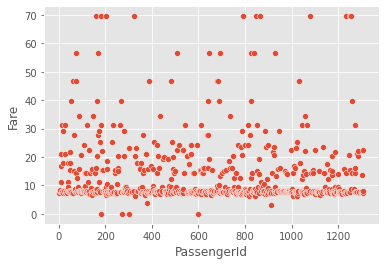

In [368]:
pclass3 = all[all['Pclass']==3]
sns.scatterplot(x='PassengerId', y='Fare', data=pclass3)
pclass3['Fare'].describe()

けっこうばらついてますね。対象者のtikcet_countが1なのでそれでしぼってみる。

count    470.000000
mean       7.889955
std        1.031871
min        3.170800
25%        7.650000
50%        7.839600
75%        8.050000
max       19.966700
Name: Fare, dtype: float64

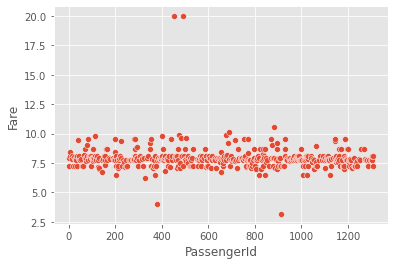

In [369]:
pclass3Solo = pclass3[pclass3['ticket_count'] == 1]
sns.scatterplot(x='PassengerId', y='Fare', data=pclass3Solo)
pclass3Solo['Fare'].describe()

かなりきれいになった。10以上のものがほとんどなくなってる。複数でTicketを買ってるとFareは合計の金額になってると考えられる。（一人当たりの料金については別途考える。）外れ値があるので、median()で補完する。

In [370]:
all.loc[all['PassengerId']==1044, 'Fare'] = pclass3Solo['Fare'].median()

## 3.2. Embarkedの補完

In [371]:
all[all['Embarked'].isnull()]

PassengerId  Survived  Pclass  ... group_id group_type  group_size
61          62.0       1.0     1.0  ...   113572          b           2
829        830.0       1.0     1.0  ...   113572          b           2

[2 rows x 22 columns]

In [372]:
pclass1 = all[all['Pclass']==1]
pclass1[['Embarked', 'PassengerId']].groupby('Embarked').count()

PassengerId
Embarked             
C                 141
Q                   3
S                 177

In [373]:
pclass1_t6 = all[(all['Pclass']==1) & (all['Ticket'].str.len()==6)]
pclass1_t6[['Embarked', 'PassengerId']].groupby('Embarked').count()

PassengerId
Embarked             
C                  21
S                  78

Sが多いのでここはSにしておく。

In [374]:
all.loc[all['Embarked'].isnull(), 'Embarked'] = 'S'
all[all['Ticket']=='113572']

PassengerId  Survived  Pclass  ... group_id group_type  group_size
61          62.0       1.0     1.0  ...   113572          b           2
829        830.0       1.0     1.0  ...   113572          b           2

[2 rows x 22 columns]

## 3.3 Ageの補完
titleを使って補完する。

In [375]:
all['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Jonkheer          1
Don               1
Lady              1
Dona              1
Capt              1
Mme               1
the Countess      1
Sir               1
Name: title, dtype: int64

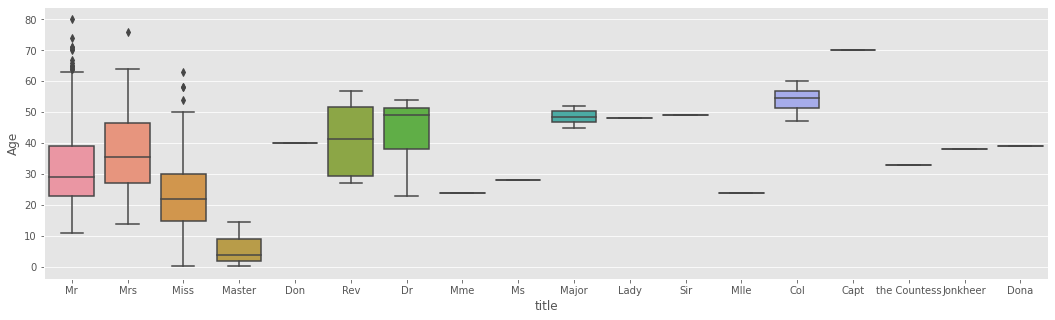

In [376]:
plt.figure(figsize=(18, 5))
sns.boxplot(x='title', y='Age',data=all)

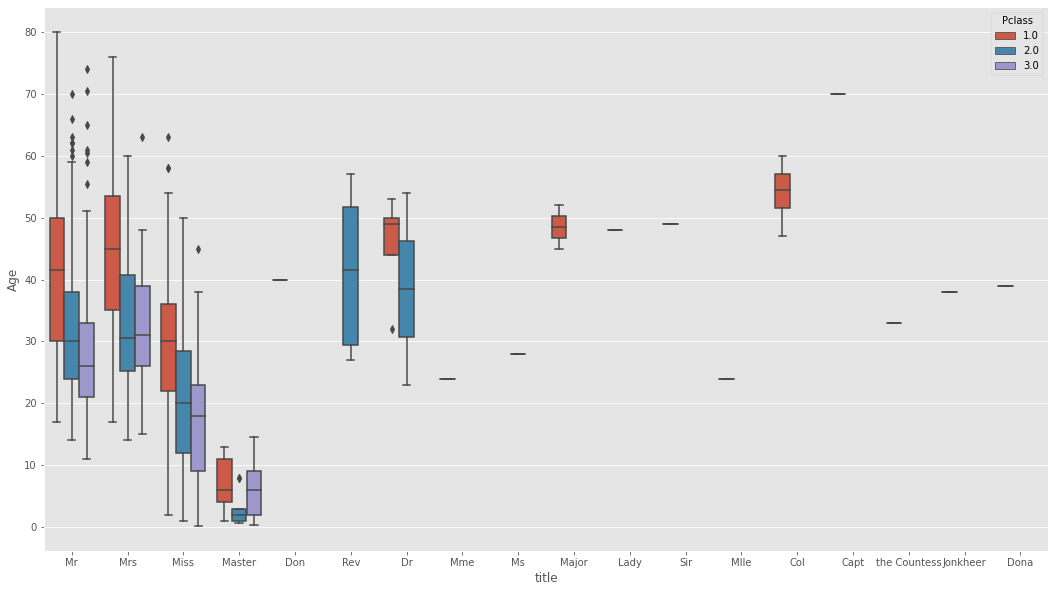

In [377]:
plt.figure(figsize=(18, 10))
sns.boxplot(x='title', y='Age',hue='Pclass', data=all)

Pclassが違うと年齢の分布も違うように見える。

基本的には平均値で補完すればいいが、980はMsなので平均値が計算できない。

In [378]:
all[(all['Age'].isnull()) & (all.title != 'Mr') & (all.title != 'Mrs') & (all.title != 'Miss') & (all.title != 'Master')]

PassengerId  Survived  Pclass  ... group_id group_type  group_size
766        767.0       0.0     1.0  ...   112379       solo           1
979        980.0       NaN     3.0  ...   364856       solo           1

[2 rows x 22 columns]

In [379]:
all[['Pclass', 'title', 'Age']].groupby(['Pclass', 'title']).mean()

Age
Pclass title                  
1.0    Capt          70.000000
       Col           54.000000
       Don           40.000000
       Dona          39.000000
       Dr            45.600000
       Jonkheer      38.000000
       Lady          48.000000
       Major         48.500000
       Master         6.984000
       Miss          30.338983
       Mlle          24.000000
       Mme           24.000000
       Mr            41.450758
       Mrs           43.208955
       Sir           49.000000
       the Countess  33.000000
2.0    Dr            38.500000
       Master         2.757273
       Miss          20.717083
       Mr            32.346715
       Mrs           33.518519
       Ms            28.000000
       Rev           41.250000
3.0    Master         6.090000
       Miss          17.360874
       Mr            28.318910
       Mrs           32.326531
       Ms                  NaN

In [380]:
all[(all['title']=='Miss') & (all['Pclass']==3)]['Age'].quantile([0.5, 0.75, 0.9])

0.50    18.0
0.75    23.0
0.90    29.8
Name: Age, dtype: float64

In [381]:
all[(all['title']=='Miss') & (all['Age']<1)]['Age'].describe()

count    4.000000
mean     0.647500
std      0.328266
min      0.170000
25%      0.605000
50%      0.750000
75%      0.792500
max      0.920000
Name: Age, dtype: float64

In [382]:
all['title_age'] = all.groupby(['title'])['Age'].transform('mean')
all.loc[(all['Age'].isnull()) & ( (all.title=='Dr') | (all.title=='Ms')), 'Age'] = all['title_age']

In [383]:
all['title_age'] = all.groupby(['Pclass', 'title'])['Age'].transform('mean')
all.loc[(all['Age'].isnull()), 'Age'] = all['title_age']

all = all.drop(['title_age'], axis=1)
all[all['Age'].isnull()]

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, family_name, title, given_name, maiden_name, maiden_or_family, family_size, ticket_count, group_id, group_type, group_size]
Index: []

# 4. Feature Engineering

## 4.1. 一人当たりの料金

同じTicketを使って乗ってる場合、Fareは全員分の料金のように見える。一人当たりの料金を表す属性を追加する。

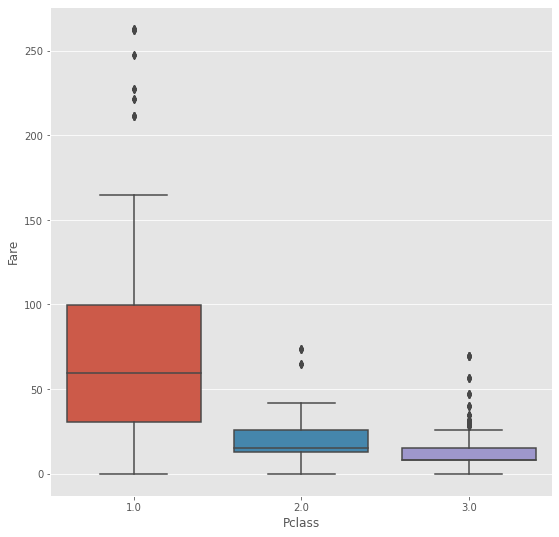

In [384]:
lt_500 = all[all['Fare']< 500]
plt.figure(figsize=(9, 9))
sns.boxplot(x='Pclass', y='Fare', data=lt_500)

In [385]:
all['price'] = all['Fare'] / all['ticket_count']

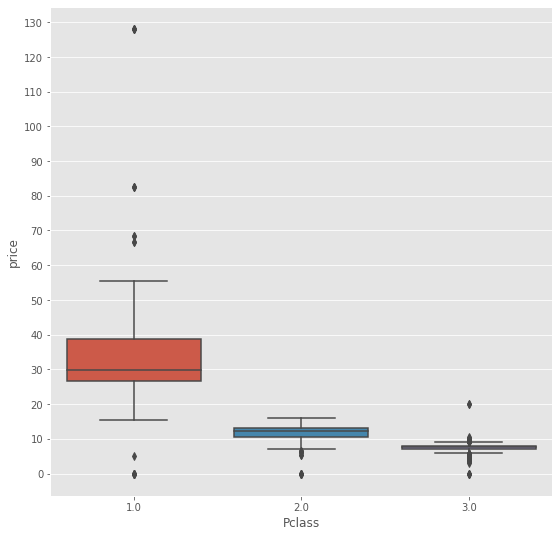

In [386]:
import matplotlib.ticker as ticker
plt.figure(figsize=(9, 9))
sns.boxplot(x='Pclass', y='price', data=all)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

Pclass3でPclass2より高いのがいるので見てみましょう。

In [387]:
all[(all['price']>19) & (all['Pclass']==3)]

PassengerId  Survived  Pclass  ... group_type group_size    price
451        452.0       0.0     3.0  ...          c          2  19.9667
490        491.0       0.0     3.0  ...          c          2  19.9667

[2 rows x 23 columns]

特に変なところはない

## 4.2. お世話する人される人

グループ内の助ける側の人や助けられる側の人を特徴量に追加する前にまずそれぞれの人が助ける側か助けられる側かを表す属性を追加する。

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



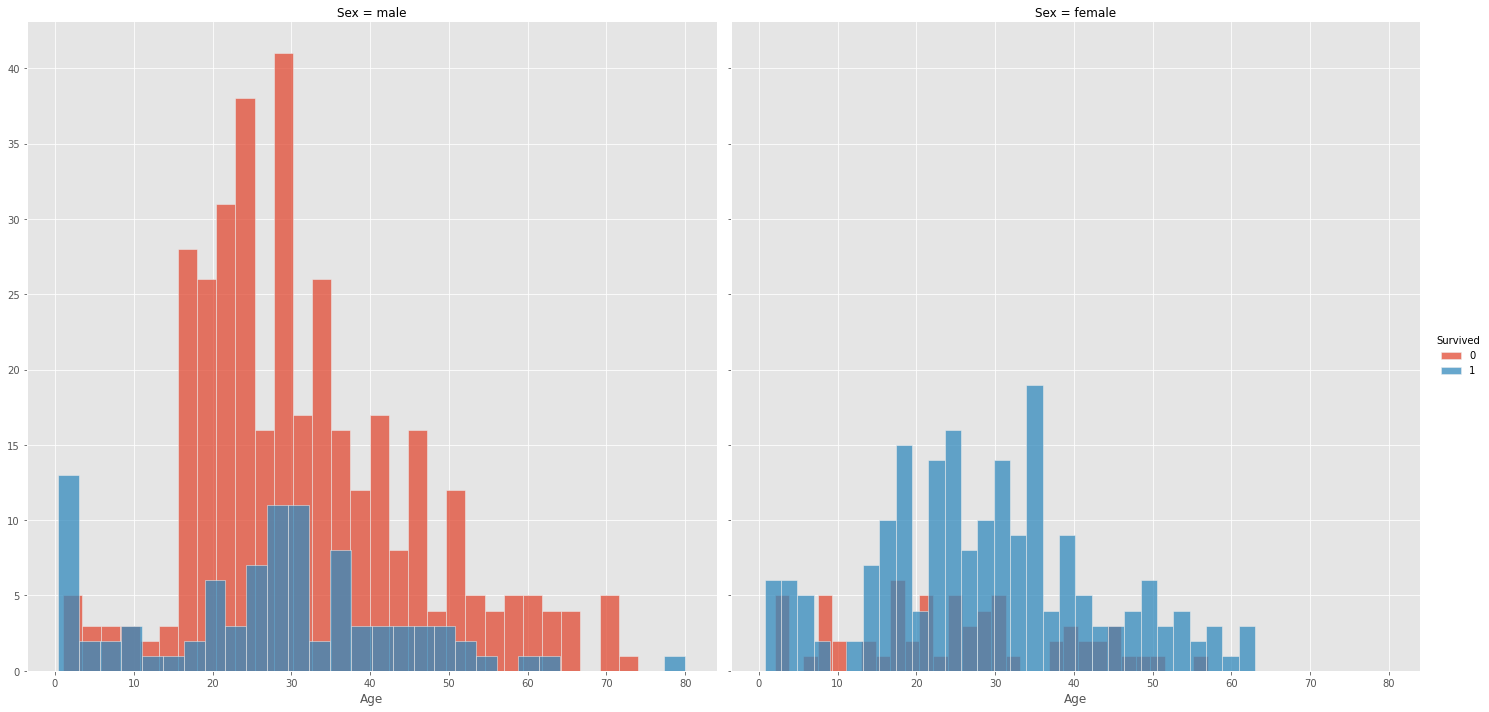

In [388]:
g = sns.FacetGrid(train, col='Sex', hue='Survived', size=10)
g.map(sns.histplot, 'Age', bins=30)
g.add_legend()

In [389]:
helpers = train[(train['Sex']=='male') & (train['Age']>=16) &(train['Age']<17)]                                              
survived(helpers)

PassengerId      rate
Survived                       
0                  10  0.909091
1                   1  0.090909

16歳から急に死ぬ人が増えてるので、16歳以上の男を助ける側とする。

In [390]:
all.loc[((all['Sex']=='male') & (all['Age']>=16)), 'is_helper'] = 1
all['is_helper'].fillna(0, inplace=True)
all['is_helper'] = all['is_helper'].astype(int)
all

PassengerId  Survived  Pclass  ... group_size      price  is_helper
0             1.0       0.0     3.0  ...          2   7.250000          1
1             2.0       1.0     1.0  ...          2  35.641650          0
2             3.0       1.0     3.0  ...          1   7.925000          0
3             4.0       1.0     1.0  ...          2  26.550000          0
4             5.0       0.0     3.0  ...          1   8.050000          1
...           ...       ...     ...  ...        ...        ...        ...
1304       1305.0       NaN     3.0  ...          1   8.050000          1
1305       1306.0       NaN     1.0  ...          3  36.300000          0
1306       1307.0       NaN     3.0  ...          1   7.250000          1
1307       1308.0       NaN     3.0  ...          1   8.050000          1
1308       1309.0       NaN     3.0  ...          3   7.452767          0

[1309 rows x 24 columns]

## 4.3. 無料で乗ってる人

In [391]:
price_0 = all[all['price']==0.0]
survived(price_0)

PassengerId      rate
Survived                       
0.0                14  0.933333
1.0                 1  0.066667

ほとんで死んでる。titleはMr かJonkeer （貴族の称号）

price==0の人をみてみる。

In [392]:
price_0

PassengerId  Survived  Pclass  ... group_size price  is_helper
179         180.0       0.0     3.0  ...          4   0.0          1
263         264.0       0.0     1.0  ...          1   0.0          1
271         272.0       1.0     3.0  ...          4   0.0          1
277         278.0       0.0     2.0  ...          3   0.0          1
302         303.0       0.0     3.0  ...          4   0.0          1
413         414.0       0.0     2.0  ...          3   0.0          1
466         467.0       0.0     2.0  ...          3   0.0          1
481         482.0       0.0     2.0  ...          1   0.0          1
597         598.0       0.0     3.0  ...          4   0.0          1
633         634.0       0.0     1.0  ...          1   0.0          1
674         675.0       0.0     2.0  ...          1   0.0          1
732         733.0       0.0     2.0  ...          1   0.0          1
806         807.0       0.0     1.0  ...          1   0.0          1
815         816.0       0.0     1.0  ...          2   0.0          1
822         823.0       0.0     1.0  ...          1   0.0          1
1157       1158.0       NaN     1.0  ...          1   0.0          1
1263       1264.0       NaN     1.0  ...          2   0.0          1

[17 rows x 24 columns]

次に０じゃないけどほぼ０の客を探す

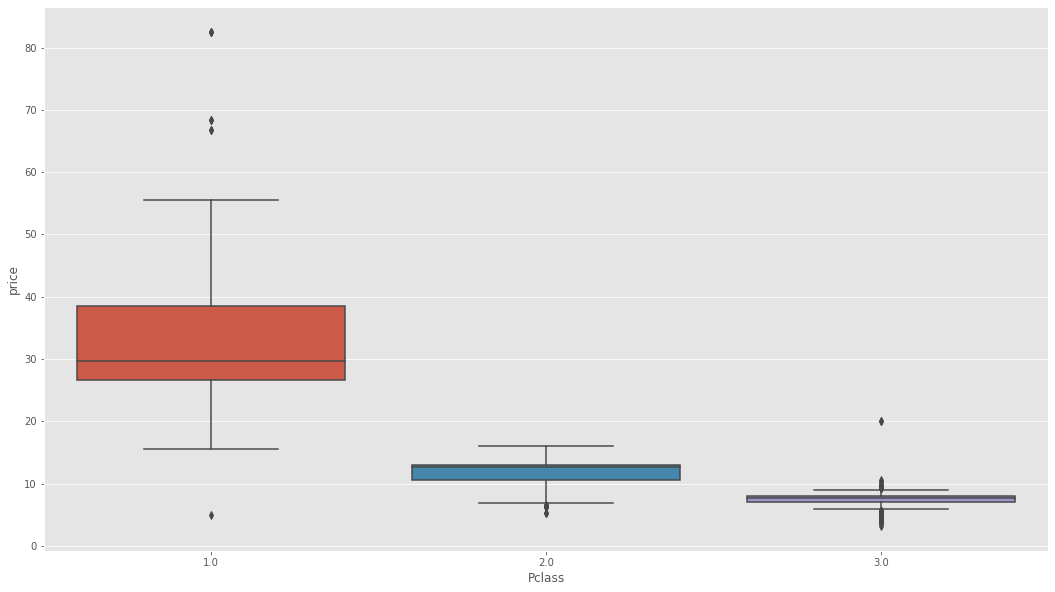

In [393]:
plt.figure(figsize=(18, 10))
all_x = all[(all['price']>0) & (all['price']<120)]
sns.boxplot(x='Pclass', y='price',data=all_x)

In [394]:
pclass1 = all[all.Pclass==1]
pclass1[(pclass1['price']>0) &(pclass1['price']<6)]

PassengerId  Survived  Pclass  ... group_size price  is_helper
872        873.0       0.0     1.0  ...          1   5.0          1

[1 rows x 24 columns]

873は5$はらってるけど、安すぎる、男、大人なので無料客とみなす。

In [395]:
pclass2 = all[all['Pclass']==2]
pclass2[(pclass2['price']>0) & (pclass2['price'] < 7)]

PassengerId  Survived  Pclass  ... group_size   price  is_helper
58           59.0       1.0     2.0  ...          4  6.9375          0
407         408.0       1.0     2.0  ...          3  6.2500          0
437         438.0       1.0     2.0  ...          3  6.2500          0
450         451.0       0.0     2.0  ...          4  6.9375          1
472         473.0       1.0     2.0  ...          4  6.9375          0
714         715.0       0.0     2.0  ...          2  6.5000          1
772         773.0       0.0     2.0  ...          2  5.2500          0
800         801.0       0.0     2.0  ...          2  6.5000          1
831         832.0       1.0     2.0  ...          3  6.2500          0
841         842.0       0.0     2.0  ...          2  5.2500          1
1141       1142.0       NaN     2.0  ...          4  6.9375          0

[11 rows x 24 columns]

773と842は親戚かなんかかな。他の無料客は全部男、Ticketが全然違う、金額が飛び抜けて安いやけじゃない、ということでこれは無料客とは見なさない。

In [396]:
pclass3 = all[all['Pclass']==3]
pclass3[(pclass3['price']>0) & (pclass3['price'] < 4)]

PassengerId  Survived  Pclass  ... group_size   price  is_helper
8            9.0       1.0     3.0  ...          3  3.7111          0
172        173.0       1.0     3.0  ...          3  3.7111          0
869        870.0       1.0     3.0  ...          3  3.7111          0
912        913.0       NaN     3.0  ...          2  3.1708          0

[4 rows x 24 columns]

913は子供（他の無料客は全部成人男性）なので違う。

In [397]:
all.loc[(all['price']==0), 'free_ticket'] = 1
all.loc[(all['PassengerId']==873), 'free_ticket'] = 1
all['free_ticket'].fillna(0, inplace=True)
all['free_ticket'] = all['free_ticket'].astype(int)



## 4.4. Cabin

In [398]:
cabin_null = all[all['Cabin'].isnull()]
survived(cabin_null)

PassengerId      rate
Survived                       
0.0               481  0.700146
1.0               206  0.299854

In [399]:
cabin_exist = train[train['Cabin'].isnull() == False]
survived(cabin_exist)

PassengerId      rate
Survived                       
0                  68  0.333333
1                 136  0.666667

In [400]:
all['null_cabin'] = all['Cabin'].isnull() * 1

## 4.5. グループ内の助ける人、助けられる人

In [401]:
all['is_s_helper'] = all['is_helper'] * all['Survived']
all['is_s_helper'].fillna(0, inplace=True)
all['is_s_helper'] = all['is_s_helper'].astype(int)

In [402]:
all['is_d_helper'] = all['is_helper'] * (1 - all['Survived'])
all['is_d_helper'].fillna(0, inplace=True)
all['is_d_helper'] = all['is_d_helper'].astype(int)

In [403]:
all['is_u_helper'] = all['is_helper'] * all['Survived'].isnull()
all['is_u_helper'].fillna(0, inplace=True)
all['is_u_helper'] = all['is_u_helper'].astype(int)

In [404]:
all['g_s_helpers'] = all.groupby('group_id')['is_s_helper'].transform('sum')
all['g_d_helpers'] = all.groupby('group_id')['is_d_helper'].transform('sum')
all['g_u_helpers'] = all.groupby('group_id')['is_u_helper'].transform('sum')

このままでは、自分自身の情報がg_x_helpersに入ってしまう。これは、だめなので自分の分をg_x_helpersから取り除くようにする。

In [405]:
all.loc[(all.is_s_helper==1), 'g_s_helpers'] = all['g_s_helpers'] - 1
all.loc[(all.is_d_helper==1), 'g_d_helpers'] = all['g_d_helpers'] - 1
all.loc[(all.is_u_helper==1), 'g_u_helpers'] = all['g_u_helpers'] - 1

助けられる側の方の情報も追加すべき。g_s_helpeeとか。

In [406]:
all['is_s_helpee'] = (1 - all['is_helper']) * all['Survived']
all['is_s_helpee'].fillna(0, inplace=True)
all['is_s_helpee'] = all['is_s_helpee'].astype(int)

all['is_d_helpee'] = (1 - all['is_helper']) * (1 - all['Survived'])
all['is_d_helpee'].fillna(0, inplace=True)
all['is_d_helpee'] = all['is_d_helpee'].astype(int)

all['is_u_helpee'] = (1 - all['is_helper']) * all['Survived'].isnull()
all['is_u_helpee'].fillna(0, inplace=True)
all['is_u_helpee'] = all['is_u_helpee'].astype(int)

In [407]:
all['g_s_helpees'] = all.groupby('group_id')['is_s_helpee'].transform('sum')
all['g_d_helpees'] = all.groupby('group_id')['is_d_helpee'].transform('sum')
all['g_u_helpees'] = all.groupby('group_id')['is_u_helpee'].transform('sum')

In [408]:
all.loc[(all.is_s_helpee==1), 'g_s_helpees'] = all['g_s_helpees'] - 1
all.loc[(all.is_d_helpee==1), 'g_d_helpees'] = all['g_d_helpees'] - 1
all.loc[(all.is_u_helpee==1), 'g_u_helpees'] = all['g_u_helpees'] - 1

In [409]:
all = all.drop(['is_s_helper', 'is_d_helper', 'is_u_helper', 'is_s_helpee', 'is_d_helpee', 'is_u_helpee'], axis=1)

## 4.6. 社会的身分
titleは貴族とか医者など、社会的身分や職業を表していることがある。これらも生存率に影響してくると考えられる。
Noble 男: Jonkheer, Sir, Don
Noble 女: Dona, Countess, Lady

聖職者: Rev
軍人: Col, Capt, Major
Mlle = Miss
Mme = Mrs



In [410]:
all['title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Mlle              2
Ms                2
Jonkheer          1
Don               1
Lady              1
Dona              1
Capt              1
Mme               1
the Countess      1
Sir               1
Name: title, dtype: int64

In [411]:
all['title'] = all['title'].replace(['Mlle', 'Ms'], 'Miss')
all['title'] = all['title'].replace('Mme', 'Mrs')
all['title'] = all['title'].replace(['Col', 'Major', 'Capt'], 'Army')
all['title'] = all['title'].replace(['Jonkheer', 'Sir', 'Don', 'Dona', 'the Countess', 'Lady'], 'Noble')

all['title'].value_counts()



Mr        757
Miss      264
Mrs       198
Master     61
Rev         8
Dr          8
Army        7
Noble       6
Name: title, dtype: int64

# 5. きれいにする

In [412]:
all.dtypes

PassengerId         float64
Survived            float64
Pclass              float64
Name                 object
Sex                  object
Age                 float64
SibSp               float64
Parch               float64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
family_name          object
title                object
given_name           object
maiden_name          object
maiden_or_family     object
family_size         float64
ticket_count        float64
group_id             object
group_type           object
group_size            int64
price               float64
is_helper             int64
free_ticket           int64
null_cabin            int64
g_s_helpers           int64
g_d_helpers           int64
g_u_helpers           int64
g_s_helpees           int64
g_d_helpees           int64
g_u_helpees           int64
dtype: object

In [413]:
all2 = all.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'family_name', 'given_name', 'maiden_name', 'maiden_or_family', 'group_id', 'group_type', 'SibSp', 'Parch', 'family_size', 'ticket_count'], axis=1)

In [414]:
all2['Pclass'] = all2['Pclass'].astype(int)

In [415]:
all2.isnull().sum()

Survived       418
Pclass           0
Sex              0
Age              0
Embarked         0
title            0
group_size       0
price            0
is_helper        0
free_ticket      0
null_cabin       0
g_s_helpers      0
g_d_helpers      0
g_u_helpers      0
g_s_helpees      0
g_d_helpees      0
g_u_helpees      0
dtype: int64

In [416]:
cats = all2.columns[all2.dtypes=='object']
cats

Index(['Sex', 'Embarked', 'title'], dtype='object')

In [417]:
from sklearn.preprocessing import LabelEncoder
for c in cats:
  le = LabelEncoder()
  le = le.fit(all2[c])
  all2[c] = le.transform(all2[c])


In [418]:
train2 = all2[all2['Survived'].notnull()].reset_index(drop=True)
train2.corr()

Survived    Pclass  ...  g_d_helpees  g_u_helpees
Survived     1.000000 -0.338481  ...    -0.198698     0.083455
Pclass      -0.338481  1.000000  ...     0.207448    -0.066889
Sex         -0.543351  0.131900  ...    -0.065486    -0.128869
Age         -0.072144 -0.406932  ...    -0.247189    -0.168140
Embarked    -0.167675  0.162098  ...     0.098774    -0.048300
title       -0.076721 -0.051554  ...    -0.184533    -0.174370
group_size   0.055834 -0.032051  ...     0.665385     0.619413
price        0.288337 -0.762981  ...    -0.172708     0.108692
is_helper   -0.558221  0.086282  ...    -0.223201    -0.228535
free_ticket -0.089351 -0.070176  ...    -0.037403    -0.055481
null_cabin  -0.316912  0.725541  ...     0.133699    -0.098717
g_s_helpers  0.119663 -0.017494  ...    -0.043960    -0.036587
g_d_helpers  0.012791 -0.006405  ...     0.194811     0.185000
g_u_helpers  0.034372 -0.077998  ...     0.151727     0.242768
g_s_helpees  0.296298 -0.306894  ...    -0.096062     0.182969
g_d_helpees -0.198698  0.207448  ...     1.000000     0.292297
g_u_helpees  0.083455 -0.066889  ...     0.292297     1.000000

[17 rows x 17 columns]

In [419]:
train_X = train2.drop(['Survived'], axis=1)
train_Y = train2['Survived']

In [420]:
test_X = all2[all2['Survived'].isnull()].drop(['Survived'],axis=1).reset_index(drop=True)

# 4. モデル

In [421]:
cat_feature = ['Pclass', 'Sex', 'Embarked', 'title', 'is_helper', 'free_ticket', 'null_cabin']
for f in cat_feature:
  train_X[f] = train_X[f].astype('category')
  test_X[f] = test_X[f].astype('category')

### パラメータ最適化

In [422]:
!pip install optuna
import optuna.integration.lightgbm as olgb
from sklearn.model_selection import train_test_split

lgbm_params = {
    "objective": "binary",
    "randome_seed": 1234
}

X_train, X_val, y_train, y_val = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False, stratify=None)
lgb_train = olgb.Dataset(X_train, y_train)
lgb_eval = olgb.Dataset(X_val, y_val, reference=lgb_train)

opt = olgb.train(
    lgbm_params,
    lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=100,
    early_stopping_rounds=10,
    verbose_eval=10)

[I 2021-04-11 13:58:49,536] A new study created in memory with name: no-name-300981d1-3e4a-4dea-9dc2-7fbbed229894
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

feature_fraction, val_score: 0.294792:  29%|##8       | 2/7 [00:00<00:00, 11.50it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.38519
[20]	valid_0's binary_logloss: 0.322218
[30]	valid_0's binary_logloss: 0.30242
[40]	valid_0's binary_logloss: 0.302029
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.297982
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.385117
[20]	valid_0's binary_logloss: 0.323932


feature_fraction, val_score: 0.294792:  57%|#####7    | 4/7 [00:00<00:00, 11.12it/s]

[30]	valid_0's binary_logloss: 0.301608
[40]	valid_0's binary_logloss: 0.310094
Early stopping, best iteration is:
[32]	valid_0's binary_logloss: 0.299169
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.402986
[20]	valid_0's binary_logloss: 0.327169
[30]	valid_0's binary_logloss: 0.305806
[40]	valid_0's binary_logloss: 0.297272
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.296066
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.382882
[20]	valid_0's binary_logloss: 0.321977
[30]	valid_0's binary_logloss: 0.306876
[40]	valid_0's binary_logloss: 0.313663
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.306876


num_leaves, val_score: 0.294792:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.464055
[20]	valid_0's binary_logloss: 0.353436
[30]	valid_0's binary_logloss: 0.324758
[40]	valid_0's binary_logloss: 0.313281
[50]	valid_0's binary_logloss: 0.307646
[60]	valid_0's binary_logloss: 0.312029
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.307646
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.43133
[20]	valid_0's binary_logloss: 0.333861
[30]	valid_0's binary_logloss: 0.310545
[40]	valid_0's binary_logloss: 0.303514
[50]	valid_0's binary_logloss: 0.30146
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.300424


num_leaves, val_score: 0.294792:  10%|#         | 2/20 [00:00<00:01,  9.32it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792


num_leaves, val_score: 0.294792:  20%|##        | 4/20 [00:00<00:01,  9.35it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.395244
[20]	valid_0's binary_logloss: 0.323864


num_leaves, val_score: 0.294574:  30%|###       | 6/20 [00:00<00:01,  9.88it/s]

[30]	valid_0's binary_logloss: 0.301238
[40]	valid_0's binary_logloss: 0.296516
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294574
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618


num_leaves, val_score: 0.294574:  40%|####      | 8/20 [00:00<00:01,  9.76it/s]

[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792


num_leaves, val_score: 0.286250:  60%|######    | 12/20 [00:01<00:00, 10.75it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406474
[20]	valid_0's binary_logloss: 0.338677
[30]	valid_0's binary_logloss: 0.308747
[40]	valid_0's binary_logloss: 0.298491
[50]	valid_0's binary_logloss: 0.290784
[60]	valid_0's binary_logloss: 0.289788
[70]	valid_0's binary_logloss: 0.289495
[80]	valid_0's binary_logloss: 0.287258
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.28625
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39963
[20]	valid_0's binary_logloss: 0.330196
[30]	valid_0's binary_logloss: 0.302764
[40]	valid_0's binary_logloss: 0.298953
Early stopping, best iterat

[I 2021-04-11 13:58:51,389] Trial 18 finished with value: 0.29620118838753345 and parameters: {'num_leaves': 9}. Best is trial 17 with value: 0.2862500901089942.
num_leaves, val_score: 0.286250:  70%|#######   | 14/20 [00:01<00:00, 10.84it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.396285
[20]	valid_0's binary_logloss: 0.326241
[30]	valid_0's binary_logloss: 0.301231
[40]	valid_0's binary_logloss: 0.299221
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.296029
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185

num_leaves, val_score: 0.286250:  80%|########  | 16/20 [00:01<00:00, 10.76it/s]


[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.419767
[20]	valid_0's binary_logloss: 0.353253
[30]	valid_0's binary_logloss: 0.322987
[40]	valid_0's binary_logloss: 0.306865
[50]	valid_0's binary_logloss: 0.300718
[60]	valid_0's binary_logloss: 0.296105
[70]	valid_0's binary_logloss: 0.290595
[80]	valid_0's binary_logloss: 0.288876
[90]	valid_0's binary_logloss: 0.288497
[100]	valid_0's binary_logloss: 0.290035
Did not meet early stopping. Best iteration is:
[95]	valid_0's binary_logloss: 0.287156
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.2947

num_leaves, val_score: 0.286250:  95%|#########5| 19/20 [00:01<00:00, 10.47it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185
[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.401623
[20]	valid_0's binary_logloss: 0.3328
[30]	valid_0's binary_logloss: 0.305749
[40]	valid_0's binary_logloss: 0.293636
[50]	valid_0's binary_logloss: 0.28816
[60]	valid_0's binary_logloss: 0.287391
Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.28691
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.39536
[20]	valid_0's binary_logloss: 0.325185


bagging, val_score: 0.286250:  20%|##        | 2/10 [00:00<00:00, 14.83it/s]

[30]	valid_0's binary_logloss: 0.301618
[40]	valid_0's binary_logloss: 0.296773
Early stopping, best iteration is:
[35]	valid_0's binary_logloss: 0.294792
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.417032
[20]	valid_0's binary_logloss: 0.344329
[30]	valid_0's binary_logloss: 0.3136
[40]	valid_0's binary_logloss: 0.299391
[50]	valid_0's binary_logloss: 0.293592
[60]	valid_0's binary_logloss: 0.292648
[70]	valid_0's binary_logloss: 0.290126
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.289506
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.407999
[20]	valid_0's binary_logloss: 0.342919
[30]	valid_0's binary_logloss: 0.319013
[40]	valid_0's binary_logloss: 0.306234
[50]	valid_0's binary_logloss: 0.303824
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.302465


bagging, val_score: 0.282849:  50%|#####     | 5/10 [00:00<00:00, 14.35it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.415679
[20]	valid_0's binary_logloss: 0.347399
[30]	valid_0's binary_logloss: 0.317714
[40]	valid_0's binary_logloss: 0.30246
[50]	valid_0's binary_logloss: 0.295889
[60]	valid_0's binary_logloss: 0.28805
[70]	valid_0's binary_logloss: 0.287302
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.286011
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.413885
[20]	valid_0's binary_logloss: 0.348939
[30]	valid_0's binary_logloss: 0.324055
[40]	valid_0's binary_logloss: 0.312119
[50]	valid_0's binary_logloss: 0.309012
[60]	valid_0's binary_logloss: 0.308275
[70]	valid_0's binary_logloss: 0.306016
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.304987
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logl

bagging, val_score: 0.282849:  80%|########  | 8/10 [00:00<00:00, 13.24it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.407575
[20]	valid_0's binary_logloss: 0.341907
[30]	valid_0's binary_logloss: 0.310182
[40]	valid_0's binary_logloss: 0.299161
[50]	valid_0's binary_logloss: 0.294159
[60]	valid_0's binary_logloss: 0.291757
[70]	valid_0's binary_logloss: 0.294768
Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.290929
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.415629
[20]	valid_0's binary_logloss: 0.342018
[30]	valid_0's binary_logloss: 0.316023
[40]	valid_0's binary_logloss: 0.3094
[50]	valid_0's binary_logloss: 0.297804
[60]	valid_0's binary_logloss: 0.295233
[70]	valid_0's binary_logloss: 0.293914
[80]	valid_0's binary_logloss: 0.293086
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.292832
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.409253
[20]	valid_0's binary_logl

feature_fraction_stage2, val_score: 0.282849:  17%|#6        | 1/6 [00:00<00:00, 14.39it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.408059
[20]	valid_0's binary_logloss: 0.340507
[30]	valid_0's binary_logloss: 0.314907
[40]	valid_0's binary_logloss: 0.304386
[50]	valid_0's binary_logloss: 0.298531
[60]	valid_0's binary_logloss: 0.30307
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.298531
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.405682
[20]	valid_0's binary_logloss: 0.336064
[30]	valid_0's binary_logloss: 0.30612
[40]	valid_0's binary_logloss: 0.295335
[50]	valid_0's binary_logloss: 0.292585
[60]	valid_0's binary_logloss: 0.288655
[70]	valid_0's binary_logloss: 0.287277
[80]	valid_0's binary_logloss: 0.284823
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.283271
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.415932
[20]	valid_0's binary_logloss: 0.339936
[30]	valid_0's binary_logl

feature_fraction_stage2, val_score: 0.282849:  67%|######6   | 4/6 [00:00<00:00, 13.59it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.415932
[20]	valid_0's binary_logloss: 0.339936
[30]	valid_0's binary_logloss: 0.308107
[40]	valid_0's binary_logloss: 0.296157
[50]	valid_0's binary_logloss: 0.29131
[60]	valid_0's binary_logloss: 0.291622
Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.289954
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.405084
[20]	valid_0's binary_logloss: 0.334866
[30]	valid_0's binary_log

regularization_factors, val_score: 0.282849:   5%|5         | 1/20 [00:00<00:01, 12.04it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.405084
[20]	valid_0's binary_logloss: 0.334866
[30]	valid_0's binary_logloss: 0.308106
[40]	valid_0's binary_logloss: 0.295838
[50]	valid_0's binary_logloss: 0.291487
[60]	valid_0's binary_logloss: 0.290883
[70]	valid_0's binary_logloss: 0.291451
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.289915
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406045
[20]	valid_0's binary_lo

regularization_factors, val_score: 0.282849:  20%|##        | 4/20 [00:00<00:01, 11.78it/s][I 2021-04-11 13:58:53,742] Trial 46 finished with value: 0.29318244553874323 and parameters: {'lambda_l1': 0.0004929424432182635, 'lambda_l2': 3.768159771012437}. Best is trial 44 with value: 0.28285328363534035.


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406018
[20]	valid_0's binary_logloss: 0.340203
[30]	valid_0's binary_logloss: 0.310208
[40]	valid_0's binary_logloss: 0.300364
[50]	valid_0's binary_logloss: 0.292192
[60]	valid_0's binary_logloss: 0.289233
[70]	valid_0's binary_logloss: 0.285225
[80]	valid_0's binary_logloss: 0.284307
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282853
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.420052
[20]	valid_0's binary_logloss: 0.349559
[30]	valid_0's binary_logloss: 0.319641
[40]	valid_0's binary_logloss: 0.307224
[50]	valid_0's binary_logloss: 0.300375
[60]	valid_0's binary_logloss: 0.296678
[70]	valid_0's binary_logloss: 0.294458
[80]	valid_0's binary_logloss: 0.294658
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.294458
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_lo

regularization_factors, val_score: 0.282849:  35%|###5      | 7/20 [00:00<00:01, 11.88it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.413994
[20]	valid_0's binary_logloss: 0.346688
[30]	valid_0's binary_logloss: 0.319061
[40]	valid_0's binary_logloss: 0.309332
[50]	valid_0's binary_logloss: 0.304568
[60]	valid_0's binary_logloss: 0.302875
[70]	valid_0's binary_logloss: 0.301598
[80]	valid_0's binary_logloss: 0.299614
[90]	valid_0's binary_logloss: 0.299708
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.299336
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve

regularization_factors, val_score: 0.282849:  45%|####5     | 9/20 [00:00<00:00, 12.02it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406109
[20]	valid_0's binary_logloss: 0.340286
[30]	valid_0's binary_logloss: 0.310297
[40]	valid_0's binary_logloss: 0.300455
[50]	valid_0's binary_logloss: 0.291553
[60]	valid_0's binary_logloss: 0.290264
[70]	valid_0's binary_logloss: 0.288176
[80]	valid_0's binary_logloss: 0.290435
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.286251
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_lo

regularization_factors, val_score: 0.282849:  60%|######    | 12/20 [00:01<00:00, 11.70it/s]


Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849


regularization_factors, val_score: 0.282849:  70%|#######   | 14/20 [00:01<00:00, 11.14it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.28285
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_log

regularization_factors, val_score: 0.282849:  80%|########  | 16/20 [00:01<00:00, 11.09it/s][I 2021-04-11 13:58:54,886] Trial 59 finished with value: 0.28284966406231965 and parameters: {'lambda_l1': 1.6124529089402547e-07, 'lambda_l2': 5.122263746793945e-05}. Best is trial 56 with value: 0.2828494619437079.


[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300359
[50]	valid_0's binary_logloss: 0.292187
[60]	valid_0's binary_logloss: 0.289229
[70]	v

regularization_factors, val_score: 0.282849:  95%|#########5| 19/20 [00:01<00:00, 11.10it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300358
[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406014
[20]	valid_0's binary_logloss: 0.340199
[30]	valid_0's binary_logloss: 0.310203
[40]	valid_0's binary_logloss: 0.300359
[50]	valid_0's binary_logloss: 0.292187
[60]	valid_0's binary_logloss: 0.289229
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.28285
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_log

min_data_in_leaf, val_score: 0.282849:  20%|##        | 1/5 [00:00<00:00,  9.98it/s]

[50]	valid_0's binary_logloss: 0.292186
[60]	valid_0's binary_logloss: 0.289228
[70]	valid_0's binary_logloss: 0.285222
[80]	valid_0's binary_logloss: 0.284304
Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.282849
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.401179
[20]	valid_0's binary_logloss: 0.330037
[30]	valid_0's binary_logloss: 0.309239
[40]	valid_0's binary_logloss: 0.301229
[50]	valid_0's binary_logloss: 0.298813
[60]	valid_0's binary_logloss: 0.297871
[70]	valid_0's binary_logloss: 0.295747
[80]	valid_0's binary_logloss: 0.296985
[90]	valid_0's binary_logloss: 0.297835
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.294741
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.401156
[20]	valid_0's binary_logloss: 0.327444
[30]	valid_0's binary_logloss: 0.304474
[40]	valid_0's binary_logloss: 0.297626


min_data_in_leaf, val_score: 0.282849:  80%|########  | 4/5 [00:00<00:00, 11.95it/s]

[50]	valid_0's binary_logloss: 0.294078
[60]	valid_0's binary_logloss: 0.293317
[70]	valid_0's binary_logloss: 0.290389
[80]	valid_0's binary_logloss: 0.29542
Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.289498
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.415387
[20]	valid_0's binary_logloss: 0.340806
[30]	valid_0's binary_logloss: 0.315432
[40]	valid_0's binary_logloss: 0.307928
[50]	valid_0's binary_logloss: 0.300118
[60]	valid_0's binary_logloss: 0.299603
[70]	valid_0's binary_logloss: 0.297645
[80]	valid_0's binary_logloss: 0.294203
[90]	valid_0's binary_logloss: 0.292783
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.291863
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.406295
[20]	valid_0's binary_logloss: 0.336488
[30]	valid_0's binary_logloss: 0.305856
[40]	valid_0's binary_logloss: 0.295399
[50]	valid_0's binary_logloss: 0.288384
[60]	va

min_data_in_leaf, val_score: 0.282849: 100%|##########| 5/5 [00:00<00:00, 11.14it/s]

Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.435065
[20]	valid_0's binary_logloss: 0.380606
[30]	valid_0's binary_logloss: 0.35836
[40]	valid_0's binary_logloss: 0.348223
[50]	valid_0's binary_logloss: 0.341729
[60]	valid_0's binary_logloss: 0.336279
[70]	valid_0's binary_logloss: 0.33025
[80]	valid_0's binary_logloss: 0.32775
[90]	valid_0's binary_logloss: 0.325238
[100]	valid_0's binary_logloss: 0.32417
Did not meet early stopping. Best iteration is:
[97]	valid_0's binary_logloss: 0.324166


In [423]:
opt.params

{'bagging_fraction': 0.9974452715214769,
 'bagging_freq': 3,
 'feature_fraction': 0.7,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'min_child_samples': 20,
 'num_leaves': 6,
 'objective': 'binary',
 'randome_seed': 1234}

### モデルの学習

In [424]:
from sklearn.model_selection import KFold
folds=3
kf = KFold(n_splits=folds)

In [425]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

models = []
for train_index, val_index in kf.split(train_X):
  print('LLLLL')
  X_train = train_X.iloc[train_index]
  X_val = train_X.iloc[val_index]
  y_train = train_Y.iloc[train_index]
  y_val = train_Y.iloc[val_index]

  lgb_train = lgb.Dataset(X_train, y_train)
  lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
  model_lgb = lgb.train(
      opt.params,
      lgb_train,
      valid_sets=lgb_eval,
      num_boost_round=100,
      early_stopping_rounds=10,
      verbose_eval=10
  )

  y_pred = model_lgb.predict(X_val, num_iteration = model_lgb.best_iteration)
  print(accuracy_score(y_val, np.round(y_pred)))

  models.append(model_lgb)

LLLLL
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.460985
[20]	valid_0's binary_logloss: 0.41804
[30]	valid_0's binary_logloss: 0.40371
[40]	valid_0's binary_logloss: 0.407827
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.40371


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



0.835016835016835
LLLLL
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.441815
[20]	valid_0's binary_logloss: 0.380827
[30]	valid_0's binary_logloss: 0.365219
[40]	valid_0's binary_logloss: 0.364376
[50]	valid_0's binary_logloss: 0.364711
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.36349
0.8417508417508418
LLLLL
Training until validation scores don't improve for 10 rounds.
[10]	valid_0's binary_logloss: 0.432007
[20]	valid_0's binary_logloss: 0.368295
[30]	valid_0's binary_logloss: 0.346248
[40]	valid_0's binary_logloss: 0.338095
[50]	valid_0's binary_logloss: 0.334496
[60]	valid_0's binary_logloss: 0.331747
[70]	valid_0's binary_logloss: 0.326785
[80]	valid_0's binary_logloss: 0.327269
[90]	valid_0's binary_logloss: 0.324955
[100]	valid_0's binary_logloss: 0.325486
Did not meet early stopping. Best iteration is:
[98]	valid_0's binary_logloss: 0.324681
0.8518518518518519


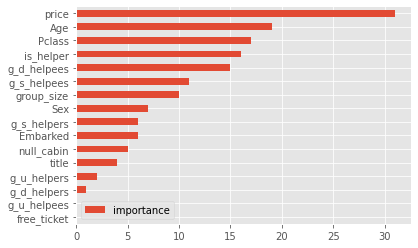

In [426]:
importance = pd.DataFrame(models[0].feature_importance(), index=train_X.columns, columns=['importance']).sort_values(by='importance', ascending=True)
importance.plot.barh()

In [427]:
preds = []
for model in models:
  pred = model.predict(test_X)
  preds.append(pred)

preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)
preds_int = (preds_mean > 0.5).astype(int)
preds_int

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [428]:
test_X[test_X['price']==0]

Pclass Sex        Age  ... g_s_helpees g_d_helpees  g_u_helpees
266      1   1  41.450758  ...           0           0            0
372      1   1  49.000000  ...           0           0            0

[2 rows x 16 columns]

# 5. Submission

In [429]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = preds_int
submission.to_csv('titanic_submit01.csv', index=False)
!kaggle competitions submit titanic -f titanic_submit01.csv -m 'utilize Ticket'
!head titanic_submit01.csv

100% 2.77k/2.77k [00:07<00:00, 401B/s]
403 - Your team has used its submission allowance (10 of 10). This resets at midnight UTC (10 hours from now).
PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


2021/4/4 score=0.77272 

2021/4/4 score=0.77033 
g_x_helpees を追加したら下がってしまった。。

2021/4/4 score=0.77511 titleを綺麗にした（NobleとかArmyでまとめた）

score=0.77990 optuna使ったらちょっと上がった。